
# Week 3 - Clustering & Topic Modeling

This week, we take a text corpus that we have developed, and we first break it into discrete document chunks through a process known as clustering or partitioning. We will pilot this here both with a well-known *flat* clustering method, `kmeans`, and also a *hierarchical* approach, `Ward's (minimum variance) method`. We will demonstrate a simple (graphical) approach to identifying optimal cluster number, the sillhouette method, and evaluate the quality of unsupervised clusters on labeled data. Next, we will explore a method of content clustering called topic modeling. This statistical technique models and computationally induces *topics* from data, which are sparse distributions over (nonexclusive clusters of) words, from which documents can formally be described as sparse mixtures. We will explore these topics and consider their utility for understanding trends within a corpus. Finally, we will consider how to construct models that take document cluster and topic loading as predictive features.

For this notebook we will be using the following packages

In [1]:
#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import nltk #the Natural Language Toolkit
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import json
import bs4

## <span style="color:red">*Your Turn*</span>

<span style="color:red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the optimal cluster number with Silhouette analysis. Plot the clusters and features after reducing with PCA. What does this cluster structure reveal about the structure of documents in your corpora? 

In [2]:
search_term = 'artificial intelligence'
NYT_api = ' '
Pages = 50

In [3]:
def getNYTarticles(search_term, api_key, pages = 5):
    '''
    --------------------------------------------------------------------
    This function gets search results of The New York Times articles
    based on the input string, api_key and the number of maximum pages
    for the search results. Its final ourput is a DataFrame object with
    columns as follows: date, section, source, text, title, url,
    word count, tokenized text, and token count.    
    --------------------------------------------------------------------
    '''
    searchDict = {
        'date' : [], #The date the article was published
        'section' : [], #The section of the article
        'source' : [], #The source of the article
        'text' : [], #The text of the article
        'title' : [], #The title of the article
        'url' : [], #The url to the article
        'word_count': [] #The total word count of the article
    }

    NYTAPItarget = 'https://api.nytimes.com/svc/search/v2/articlesearch.json?api-key={}&q={}&sort=newest&page={}'
    for page in range(pages):
        r = requests.get(NYTAPItarget.format(api_key, search_term, pages))
        response = json.loads(r.text)
        Docs = response['response']['docs']
        
        for Doc in Docs:
            #These are provided by the directory
            searchDict['date'].append(Doc['pub_date'])
            searchDict['section'].append(Doc['section_name'])
            searchDict['source'].append(Doc['source'])
            searchDict['title'].append(Doc['headline']['main'])
            searchDict['url'].append(Doc['web_url'])
            searchDict['word_count'].append(Doc['word_count'])
            
            #We need to download the text though
            text_raw = requests.get(Doc['web_url']).text
            soup = bs4.BeautifulSoup(text_raw, 'html.parser')
            pars = soup.body.findAll('p', class_= r'story-body-text')
            text_full = []
            for par in pars:
                text_full.append(par.text)
            text_clean = ' '.join(text_full)
            searchDict['text'].append(text_clean)
            
        searchDF = pandas.DataFrame(searchDict)

        #Get tokens
        searchDF['tokenized_text'] = searchDF['text'].apply(lambda x: nltk.word_tokenize(x))
        searchDF['token_counts'] = searchDF['tokenized_text'].apply(lambda x: len(x))
        
        #Delete rows with no text due to the irregularity of the original html codes
        finalDF = searchDF[searchDF['text'] != '']
    return finalDF

# NYTsample = getNYTarticles(search_term, NYT_api, Pages) # test result
# NYTsample.to_pickle('NYTsample.pkl') # pickle the result for reproducibility

In [4]:
NYTsample = pandas.read_pickle('NYTsample.pkl')
NYTsample[:20]['section']

4           Arts
5     Technology
6     Your Money
9      Education
14          Arts
15    Technology
16    Your Money
19     Education
24          Arts
25    Technology
26    Your Money
29     Education
34          Arts
35    Technology
36    Your Money
39     Education
44          Arts
45    Technology
46    Your Money
49     Education
Name: section, dtype: object

In [5]:
#Define the same function as last week; normalize tokens
def normlizeTokens(tokenLst, stopwordLst = None, stemmer = None, lemmer = None):
    #We can use a generator here as we just need to iterate over it

    #Lowering the case and removing non-words
    workingIter = (w.lower() for w in tokenLst if w.isalpha())

    #Now we can use the semmer, if provided
    if stemmer is not None:
        workingIter = (stemmer.stem(w) for w in workingIter)

    #And the lemmer
    if lemmer is not None:
        workingIter = (lemmer.lemmatize(w) for w in workingIter)

    #And remove the stopwords
    if stopwordLst is not None:
        workingIter = (w for w in workingIter if w not in stopwordLst)
    #We will return a list with the stopwords removed
    return list(workingIter)

#initialize our stemmer and our stop words
stop_words_nltk = nltk.corpus.stopwords.words('english')
snowball = nltk.stem.snowball.SnowballStemmer('english')

#Apply our functions
NYTsample['normalized_tokens'] = NYTsample['tokenized_text'].apply(lambda x: normlizeTokens(x,
                                                                                             stopwordLst = stop_words_nltk,
                                                                                             stemmer = snowball))
# NYTsample[:5]

In [6]:
# #use tf-idf to remove some of the most frequent words
# #Similar parameters to before, but stricter max df and no max num occurrences
# # NYTsampleTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
# NYTsampleTFVects = NYTsampleTFVectorizer.fit_transform(NYTsample['normalized_tokens'].sum())
# # NYTsampleTFVectorizer.vocabulary_.get('senat', 'Missing "Senate"')

# Clustering with our new data

In [7]:
# #First we will define what we will be working with
targetDF = NYTsample[11:22]
textColumn = 'reduced_tokens'
numCategories = len(set(targetDF['section']))
print(numCategories)

4


In [8]:
#Tf-IDf vectorizing
exampleTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, max_features=1000,
                                                                      min_df=3, stop_words='english', norm='l2')
#train
exampleTFVects = exampleTFVectorizer.fit_transform(targetDF['normalized_tokens'].sum())

In [9]:
#This gives us a vocabulary and we can drop now drop all the words not in it
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

NYTsample['reduced_tokens'] = NYTsample['normalized_tokens'].apply(lambda x: dropMissing(x, exampleTFVectorizer.vocabulary_.keys()))

In [10]:
#Running k means
numCategories = len(set(targetDF['section']))
print(numCategories)

exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
exampleKM.fit(exampleTFVects)

4


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [11]:
# contents of the clusters
terms = exampleTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = exampleKM.cluster_centers_.argsort()[:, ::-1]
for i in range(numCategories):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 said
 tech
 invest
 billion
 compani
 firm
 servic
 year
 ventur
 provid


Cluster 1:
 onlin
 foursquar
 fear
 favorit
 fate
 fashion
 far
 fan
 failur
 factor


Cluster 2:
 financi
 zombi
 fed
 favorit
 fate
 fashion
 far
 fan
 failur
 factor


Cluster 3:
 york
 exist
 fed
 fear
 favorit
 fate
 fashion
 far
 fan
 failur




In [12]:
# visualize
examplePCA = sklearn.decomposition.PCA(n_components = 2).fit(exampleTFVects.toarray())
reducedPCA_data = examplePCA.transform(exampleTFVects.toarray())

In [13]:
colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]

In [14]:
# optional codes for a biplot
components = examplePCA.components_
keyword_ids = list(set(order_centroids[:,:5].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

In [15]:
# building a color map for the true labels
colordict = {
'Arts': 'yellow',
'Technology': 'blue',
'Your Money': 'green',
'Education': 'red',
    }
colors = [colordict[c] for c in targetDF['section']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('Arts', 'yellow'), ('Education', 'red'), ('Your Money', 'green'), ('Technology', 'blue')])


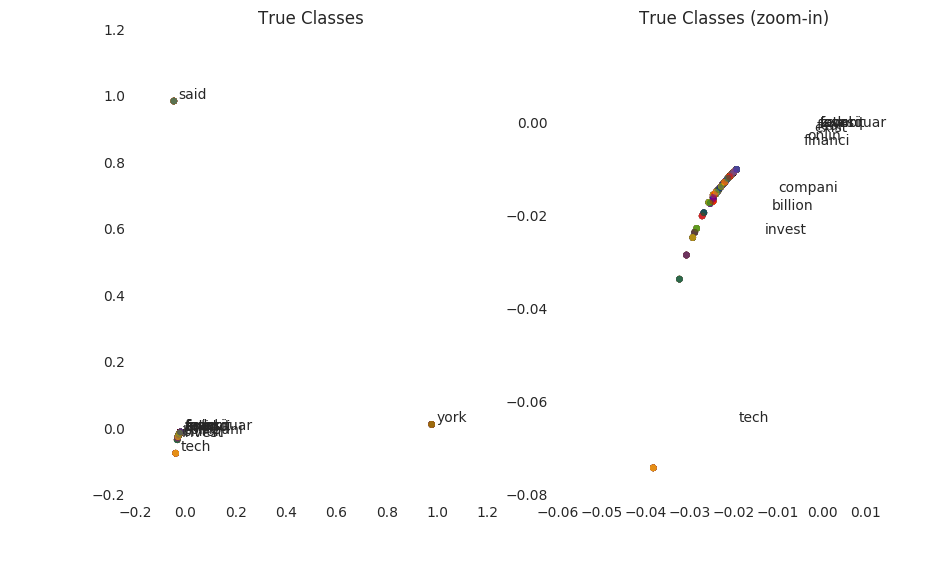

In [16]:
# plot the data with true labels
fig = plt.figure(figsize = (10,6))
ax1 = fig.add_subplot(121)
ax1.set_frame_on(False)
ax1.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words): # this part is the biplot
    ax1.annotate(word, (x[i],y[i]))
plt.title('True Classes')

ax2 = fig.add_subplot(122)
ax2.set_frame_on(False)
ax2.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words): # this part is the biplot
    ax2.annotate(word, (x[i],y[i]))
ax2.set_xlim(-0.06, 0.02)
ax2.set_ylim(-0.08, 0.02)
plt.title('True Classes (zoom-in)')

plt.show()

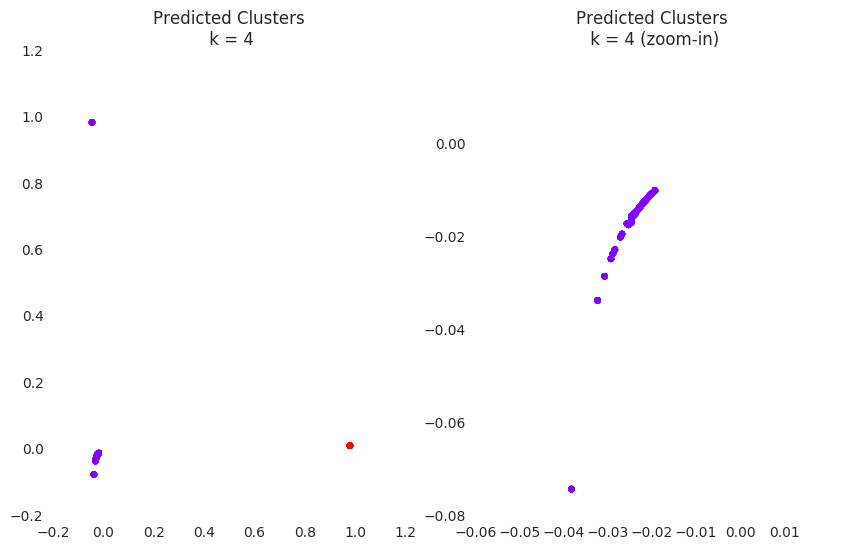

In [17]:
# # plot the data with predicted labels
fig = plt.figure(figsize = (10,6))
ax1 = fig.add_subplot(121)
ax1.set_frame_on(False)
ax1.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.3)
plt.title('Predicted Clusters\n k = {}'.format(numCategories))

ax2 = fig.add_subplot(122)
ax2.set_frame_on(False)
ax2.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.3)
plt.title('Predicted Clusters\n k = {} (zoom-in)'.format(numCategories))
ax2.set_xlim(-0.06, 0.02)
ax2.set_ylim(-0.08, 0.02)

plt.show()

For n_clusters = 2 The average silhouette_score is : 0.0868899100823


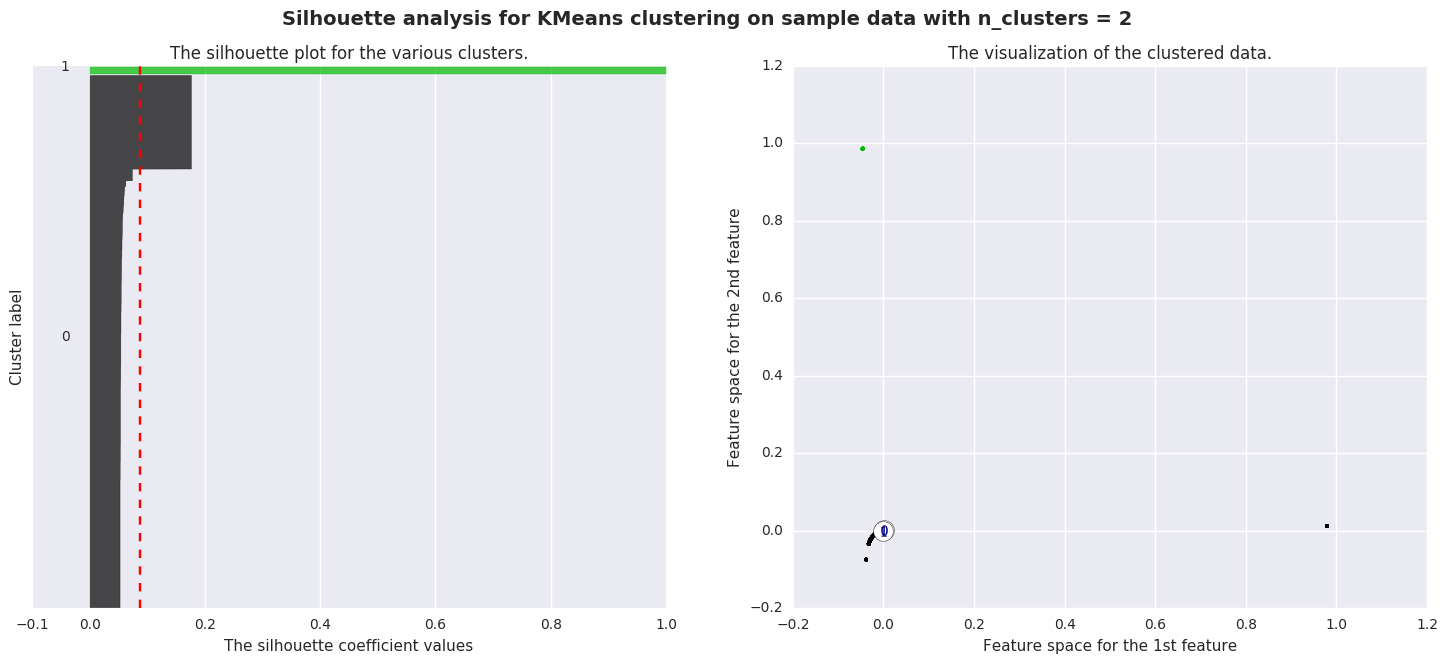

For n_clusters = 3 The average silhouette_score is : 0.0862542035643


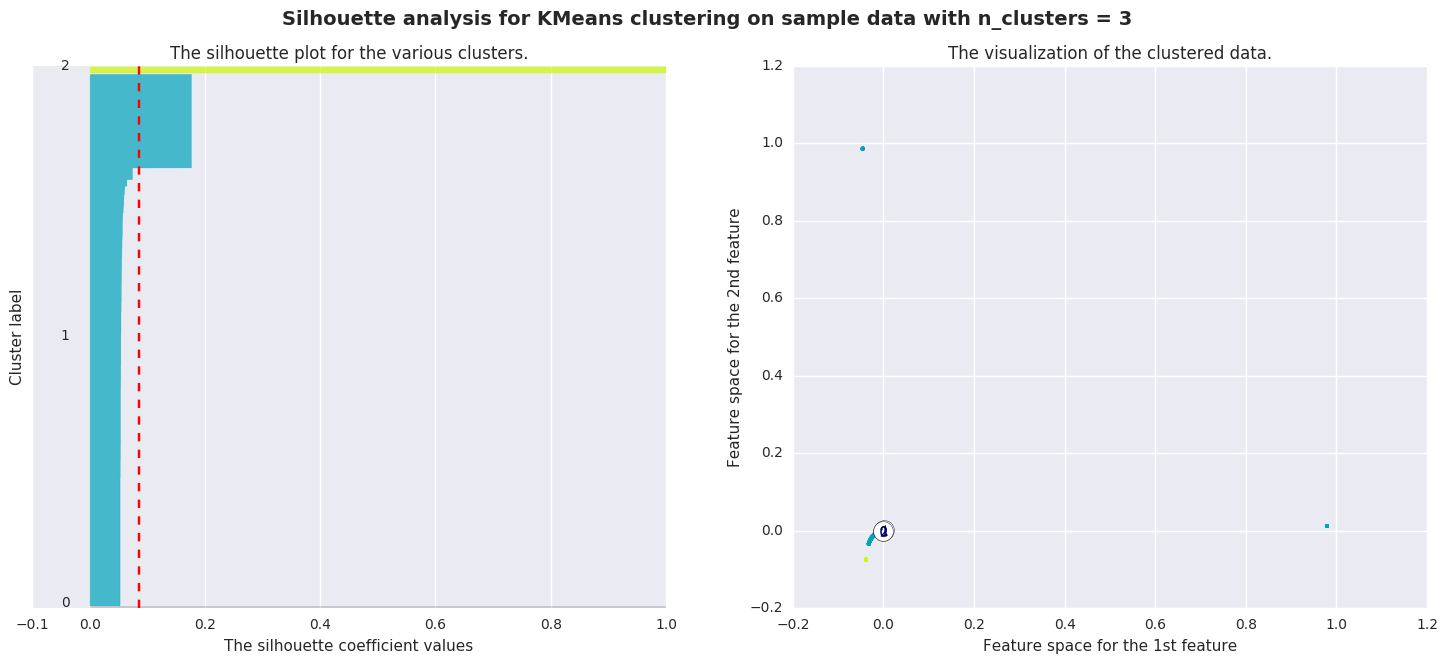

For n_clusters = 4 The average silhouette_score is : 0.104975068379


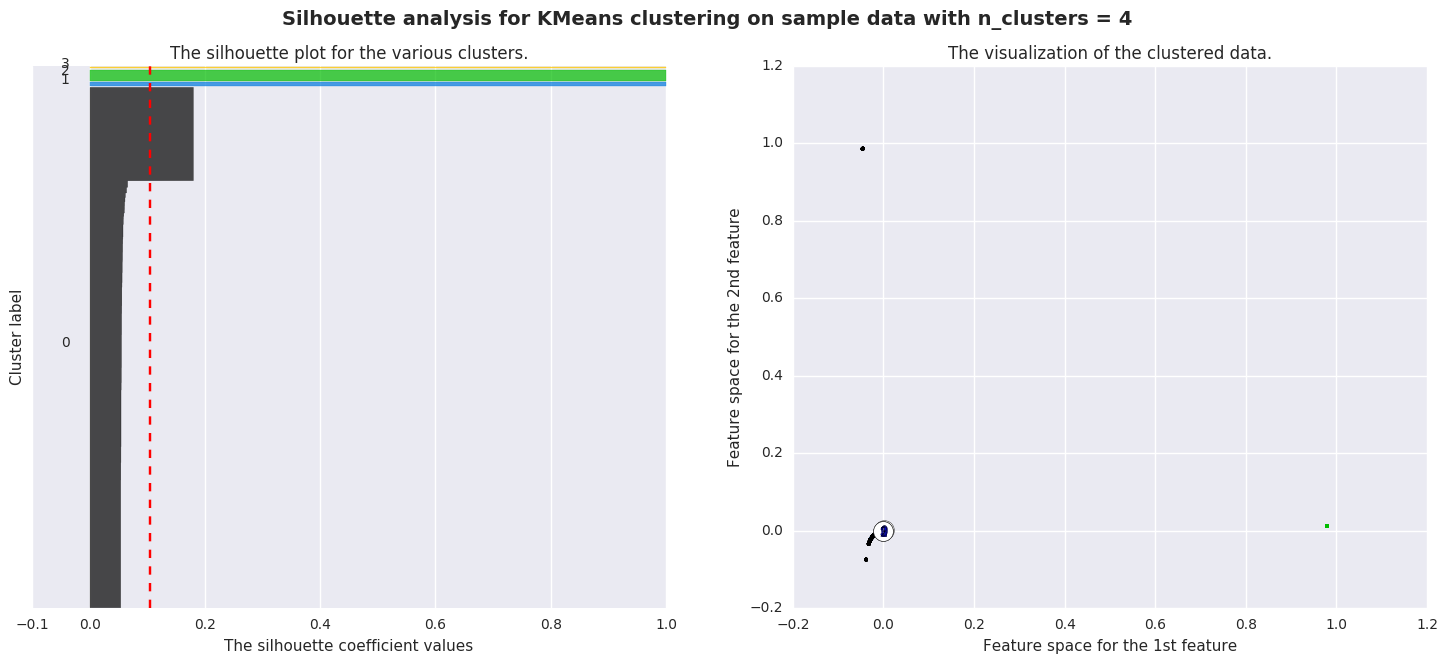

For n_clusters = 5 The average silhouette_score is : 0.112122477198


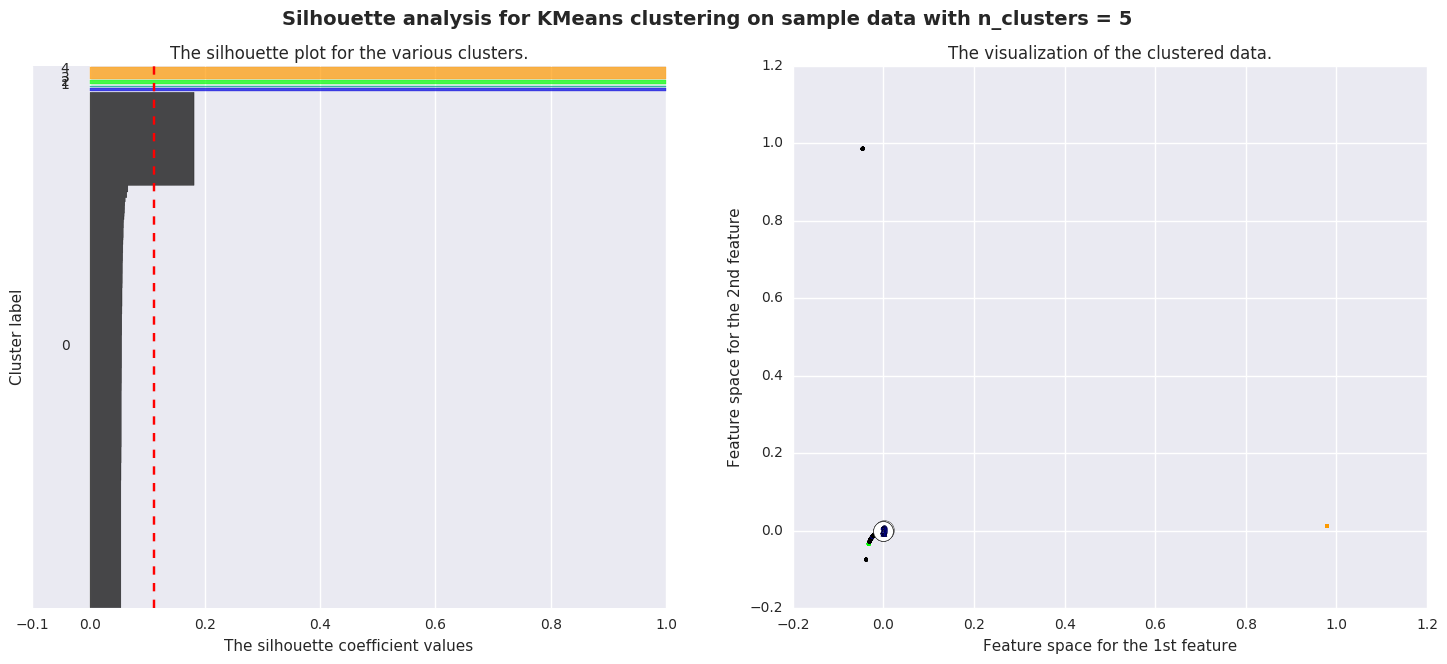

For n_clusters = 6 The average silhouette_score is : 0.113188940671


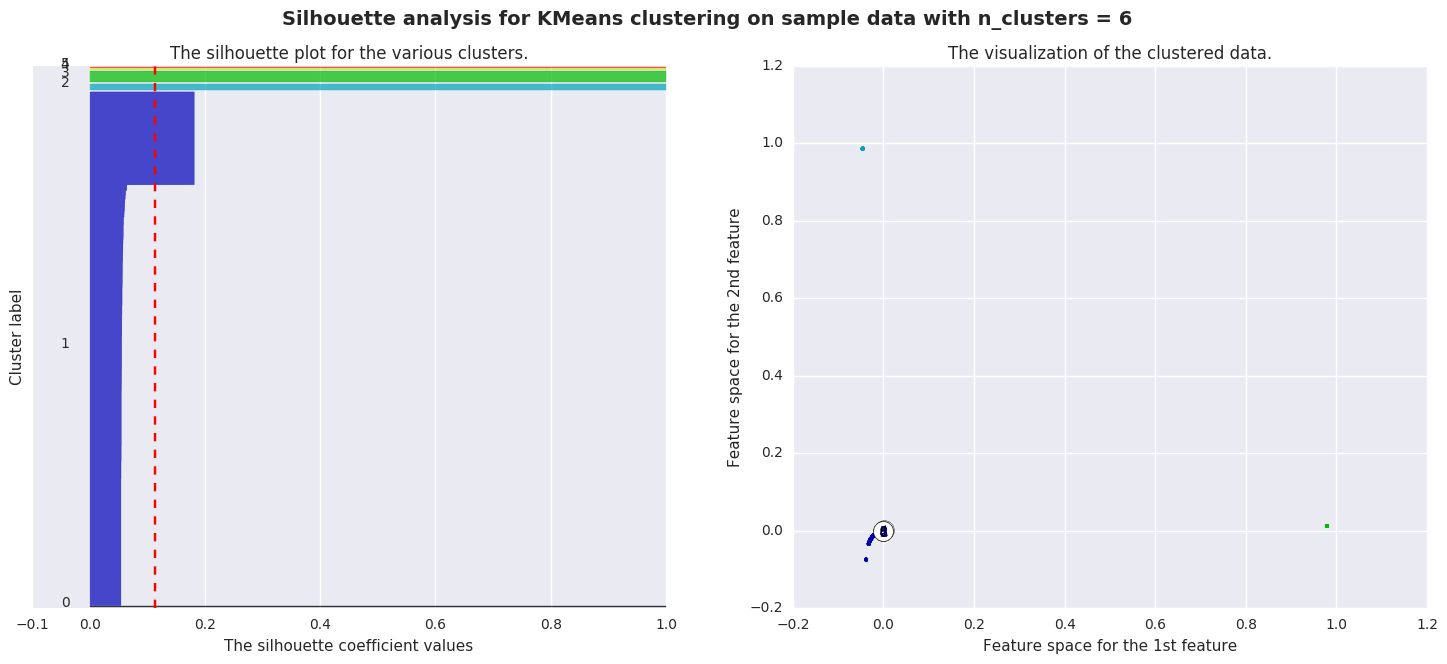

In [18]:
# silluette method to compare different numbers for K

range_n_clusters = [2, 3, 4, 5, 6]
X = exampleTFVects.toarray()

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = matplotlib.cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = matplotlib.cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

In general, the silhouette scores keep increasing with more clusters (at least up to 6), making it difficult for me to determine which is the best number of clusters for the data. The silhouette score for 4 clusters, which is in fact the actual number of sections, is approximately 0.105. 

## <span style="color:red">*Your Turn*</span>

<span style="color:red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the structure of documents in your corpora? 

In [19]:
# Here we must begin by calculating how similar the documents are to one another.

NYTsampleCoocMat = exampleTFVects * exampleTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
NYTsampleCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#NYTsampleCoocMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(exampleTFVects)

/usr/local/lib/python3.5/dist-packages/scipy/sparse/compressed.py:730: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [20]:
#compute a tree of nested clusters for the first 50 texts.
linkage_matrix = scipy.cluster.hierarchy.ward(NYTsampleCoocMat[:100, :100].toarray())
linkage_matrix[:10]

array([[   0.,    1.,    0.,    2.],
       [   2.,  100.,    0.,    3.],
       [   3.,  101.,    0.,    4.],
       [   4.,  102.,    0.,    5.],
       [   7.,  103.,    0.,    6.],
       [   8.,  104.,    0.,    7.],
       [   9.,  105.,    0.,    8.],
       [  10.,  106.,    0.,    9.],
       [  11.,  107.,    0.,   10.],
       [  12.,  108.,    0.,   11.]])

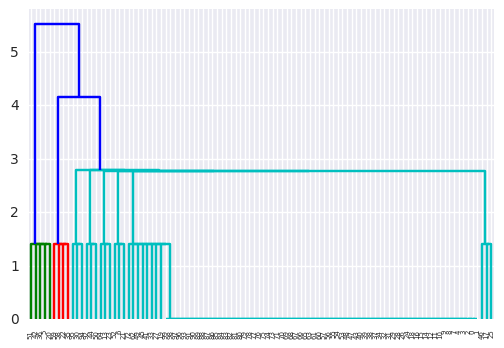

In [21]:
#visualize the tree
ax = scipy.cluster.hierarchy.dendrogram(linkage_matrix)

This plot may seem somewhat unwieldy. To make it easier to read, we can cut the tree after a number of branchings.

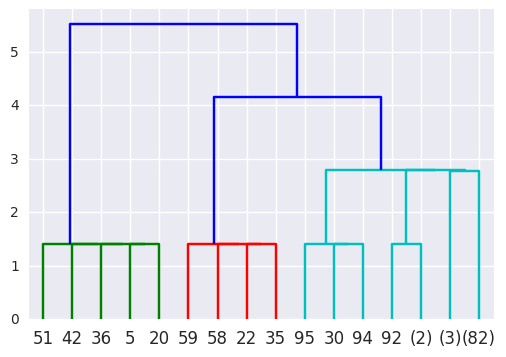

In [22]:
# cutting the tree branches a bit
ax = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level')

In [23]:
#cutting the tree after 4 branchings
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters

array([4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 2,
       4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 2, 1, 4, 4, 4, 4, 4, 1, 4, 4, 4,
       4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 3, 3, 4, 4, 4, 4], dtype=int32)

In [24]:
# array of each element of cluster
clusterLeaders = scipy.cluster.hierarchy.leaders(linkage_matrix, hierarchicalClusters)
clusterLeaders

(array([184, 195, 187, 191], dtype=int32), array([3, 4, 2, 1], dtype=int32))

In [25]:
# look the clusters up in our original data
NYTsample.iloc[clusterLeaders[0]]

,date,section,source,text,title,url,word_count,tokenized_text,token_counts,normalized_tokens,reduced_tokens
464,2016-05-03T00:00:00Z,Arts,The New York Times,"“Person of Interest” has no superheroes, no zo...","‘Person of Interest,’ Its Computers and Crime,...",http://www.nytimes.com/2016/05/03/arts/televis...,509,"[“Person, of, Interest”, has, no, superheroes,...",581,"[superhero, zombi, ninja, direwolv, much, ani,...","[superhero, zombi, ninja, direwolv, ani, telev..."
489,2016-04-28T08:15:59Z,Education,The New York Times,The following lesson activity is based on the ...,News Q&#8217;s | A Robot Monk Captivates China...,http://learning.blogs.nytimes.com/2016/04/28/n...,203,"[The, following, lesson, activity, is, based, ...",231,"[follow, lesson, activ, base, articl, robot, m...","[follow, lesson, activ, base, articl, robot, m..."
469,2016-04-28T08:15:59Z,Education,The New York Times,The following lesson activity is based on the ...,News Q&#8217;s | A Robot Monk Captivates China...,http://learning.blogs.nytimes.com/2016/04/28/n...,203,"[The, following, lesson, activity, is, based, ...",231,"[follow, lesson, activ, base, articl, robot, m...","[follow, lesson, activ, base, articl, robot, m..."
479,2016-04-28T08:15:59Z,Education,The New York Times,The following lesson activity is based on the ...,News Q&#8217;s | A Robot Monk Captivates China...,http://learning.blogs.nytimes.com/2016/04/28/n...,203,"[The, following, lesson, activity, is, based, ...",231,"[follow, lesson, activ, base, articl, robot, m...","[follow, lesson, activ, base, articl, robot, m..."


## <span style="color:red">*Your Turn*</span>

<span style="color:red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents?

<span style="color:red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</span> 

In [26]:
tokens = NYTsample.reset_index()
tokens

,index,date,section,source,text,title,url,word_count,tokenized_text,token_counts,normalized_tokens,reduced_tokens
0,4,2016-05-03T00:00:00Z,Arts,The New York Times,"“Person of Interest” has no superheroes, no zo...","‘Person of Interest,’ Its Computers and Crime,...",http://www.nytimes.com/2016/05/03/arts/televis...,509,"[“Person, of, Interest”, has, no, superheroes,...",581,"[superhero, zombi, ninja, direwolv, much, ani,...","[superhero, zombi, ninja, direwolv, ani, telev..."
1,5,2016-05-03T00:00:00Z,Technology,The New York Times,"For years, New York — a city not accustomed to...",New York City Casts a Net to Catch the Next Bi...,http://www.nytimes.com/2016/05/02/technology/n...,1279,"[For, years, ,, New, York, —, a, city, not, ac...",1480,"[year, new, york, citi, accustom, second, bana...","[year, york, citi, accustom, second, banana, l..."
2,6,2016-04-30T04:00:00Z,Your Money,The New York Times,SHOULD you trust your hard-earned retirement d...,The Pros and Cons of Using a Robot as an Inves...,http://www.nytimes.com/2016/04/30/your-money/t...,1327,"[SHOULD, you, trust, your, hard-earned, retire...",1489,"[trust, retir, dollar, robot, robot, cours, li...","[retir, dollar, robot, robot, like, capabl, pr..."
3,9,2016-04-28T08:15:59Z,Education,The New York Times,The following lesson activity is based on the ...,News Q&#8217;s | A Robot Monk Captivates China...,http://learning.blogs.nytimes.com/2016/04/28/n...,203,"[The, following, lesson, activity, is, based, ...",231,"[follow, lesson, activ, base, articl, robot, m...","[follow, lesson, activ, base, articl, robot, m..."
4,14,2016-05-03T00:00:00Z,Arts,The New York Times,"“Person of Interest” has no superheroes, no zo...","‘Person of Interest,’ Its Computers and Crime,...",http://www.nytimes.com/2016/05/03/arts/televis...,509,"[“Person, of, Interest”, has, no, superheroes,...",581,"[superhero, zombi, ninja, direwolv, much, ani,...","[superhero, zombi, ninja, direwolv, ani, telev..."
5,15,2016-05-03T00:00:00Z,Technology,The New York Times,"For years, New York — a city not accustomed to...",New York City Casts a Net to Catch the Next Bi...,http://www.nytimes.com/2016/05/02/technology/n...,1279,"[For, years, ,, New, York, —, a, city, not, ac...",1480,"[year, new, york, citi, accustom, second, bana...","[year, york, citi, accustom, second, banana, l..."
6,16,2016-04-30T04:00:00Z,Your Money,The New York Times,SHOULD you trust your hard-earned retirement d...,The Pros and Cons of Using a Robot as an Inves...,http://www.nytimes.com/2016/04/30/your-money/t...,1327,"[SHOULD, you, trust, your, hard-earned, retire...",1489,"[trust, retir, dollar, robot, robot, cours, li...","[retir, dollar, robot, robot, like, capabl, pr..."
7,19,2016-04-28T08:15:59Z,Education,The New York Times,The following lesson activity is based on the ...,News Q&#8217;s | A Robot Monk Captivates China...,http://learning.blogs.nytimes.com/2016/04/28/n...,203,"[The, following, lesson, activity, is, based, ...",231,"[follow, lesson, activ, base, articl, robot, m...","[follow, lesson, activ, base, articl, robot, m..."
8,24,2016-05-03T00:00:00Z,Arts,The New York Times,"“Person of Interest” has no superheroes, no zo...","‘Person of Interest,’ Its Computers and Crime,...",http://www.nytimes.com/2016/05/03/arts/televis...,509,"[“Person, of, Interest”, has, no, superheroes,...",581,"[superhero, zombi, ninja, direwolv, much, ani,...","[superhero, zombi, ninja, direwolv, ani, telev..."
9,25,2016-05-03T00:00:00Z,Technology,The New York Times,"For years, New York — a city not accustomed to...",New York City Casts a Net to Catch the Next Bi...,http://www.nytimes.com/2016/05/02/technology/n...,1279,"[For, years, ,, New, York, —, a, city, not, ac...",1480,"[year, new, york, citi, accustom, second, bana...","[year, york, citi, accustom, second, banana, l..."


In [27]:
# creating a corpora object to use the texts with gensim
# create a `Dictionary` that maps tokens to ids.
dictionary = gensim.corpora.Dictionary(tokens['reduced_tokens'])

# We will only use the first half of our dataset for now and will save the remainder for testing.
corpus = [dictionary.doc2bow(text) for text in tokens['reduced_tokens']]

In [28]:
# serialize the corpus as a file and load it
gensim.corpora.MmCorpus.serialize('NYTsample.mm', corpus)
NYTmm = gensim.corpora.MmCorpus('NYTsample.mm')

In [29]:
# topic modeling and induction.
NYTlda = gensim.models.ldamodel.LdaModel(corpus=NYTmm, id2word=dictionary, num_topics=4, alpha='auto', eta='auto')

In [30]:
#inspect the degree to which distinct texts load on different topics; one of the texts from the training set
NYT1Bow = dictionary.doc2bow(tokens['reduced_tokens'][0])
NYT1lda = NYTlda[NYT1Bow]
print("The topics of the text: {}".format(tokens['title'][0]))
print("are: {}".format(NYT1lda))

The topics of the text: ‘Person of Interest,’ Its Computers and Crime, Returns
are: [(0, 0.99396071783782025)]


In [31]:
# make each topic its own column:
ldaDF = pandas.DataFrame({
        'title' : tokens['title'],
        'topics' : [NYTlda[dictionary.doc2bow(l)] for l in tokens['reduced_tokens']]
    })

#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(NYTlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(NYTlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

In [32]:
ldaDF[1:20]

,title,topics,topic_0,topic_1,topic_2,topic_3
1,New York City Casts a Net to Catch the Next Bi...,"[(2, 0.99625954526)]",0.000000,0.000000,0.996260,0
2,The Pros and Cons of Using a Robot as an Inves...,"[(1, 0.997007046648)]",0.000000,0.997007,0.000000,0
3,News Q&#8217;s | A Robot Monk Captivates China...,"[(1, 0.984957280708)]",0.000000,0.984957,0.000000,0
4,"‘Person of Interest,’ Its Computers and Crime,...","[(0, 0.99395934942)]",0.993959,0.000000,0.000000,0
5,New York City Casts a Net to Catch the Next Bi...,"[(2, 0.995760094955)]",0.000000,0.000000,0.995760,0
6,The Pros and Cons of Using a Robot as an Inves...,"[(1, 0.99700596875)]",0.000000,0.997006,0.000000,0
7,News Q&#8217;s | A Robot Monk Captivates China...,"[(1, 0.984901514639)]",0.000000,0.984902,0.000000,0
8,"‘Person of Interest,’ Its Computers and Crime,...","[(0, 0.993958553146)]",0.993959,0.000000,0.000000,0
9,New York City Casts a Net to Catch the Next Bi...,"[(2, 0.996347157935)]",0.000000,0.000000,0.996347,0
10,The Pros and Cons of Using a Robot as an Inves...,"[(1, 0.997006085003)]",0.000000,0.997006,0.000000,0


In [33]:
# first, subset the data:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(4)]]
ldaDFVisN = ldaDF[:10][['title']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV

,topic_0,topic_1,topic_2,topic_3
0,0.993960,0.000000,0.000000,0
1,0.000000,0.000000,0.996260,0
2,0.000000,0.997007,0.000000,0
3,0.000000,0.984957,0.000000,0
4,0.993959,0.000000,0.000000,0
5,0.000000,0.000000,0.995760,0
6,0.000000,0.997006,0.000000,0
7,0.000000,0.984902,0.000000,0
8,0.993959,0.000000,0.000000,0
9,0.000000,0.000000,0.996347,0


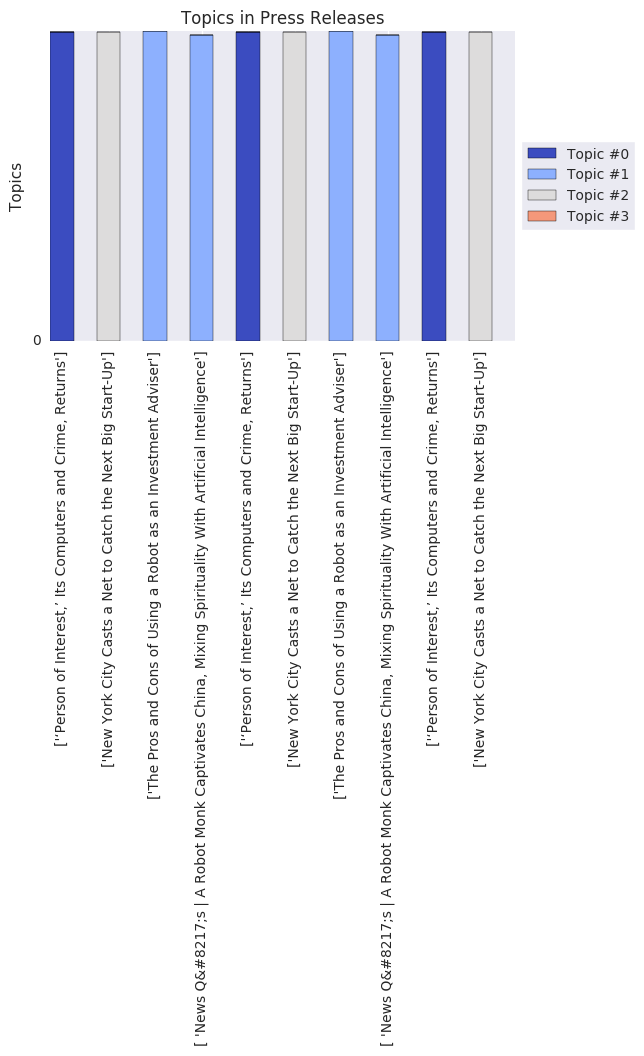

In [34]:
#visualize as a stacked bar chart:

N = 10
ind = np.arange(N)
K = NYTlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')
plt.yticks(np.arange(0, 1, 10))

topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

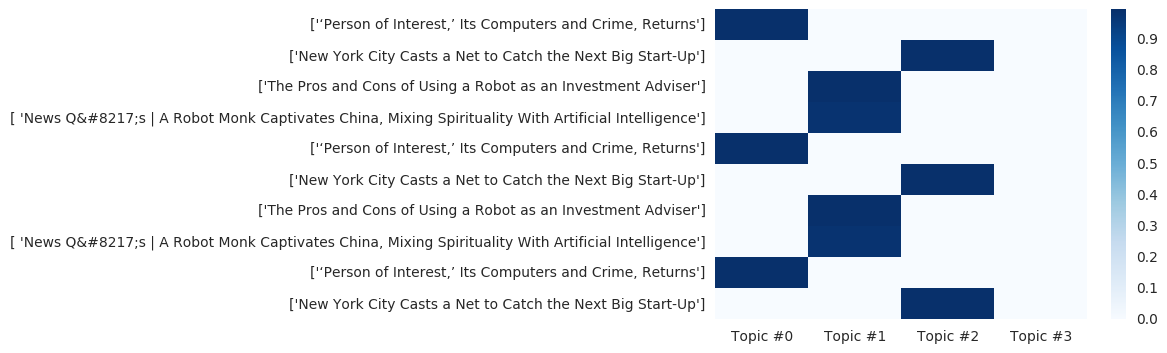

In [35]:
# visualize as a heat map:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
# plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
# plt.tight_layout()  # fixes margins
plt.show()

We can also look at the top words from each topic to get a sense of the semantic (or syntactic) domain they represent. To look at the terms with the highest LDA weight in topic `1` we can do the following:

In [36]:
#look at the top words from each topic
NYTlda.show_topic(1)

# make a dataFrame:
topicsDict = {}
for topicNum in range(NYTlda.num_topics):
    topicWords = [w for w, p in NYTlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3
0,york,invest,york,york
1,tech,said,tech,said
2,compani,investor,said,invest
3,ventur,servic,compani,servic
4,firm,provid,billion,billion
5,year,firm,ventur,firm
6,said,advis,execut,custom
7,billion,robot,silicon,advis
8,silicon,york,year,provid
9,make,custom,work,like


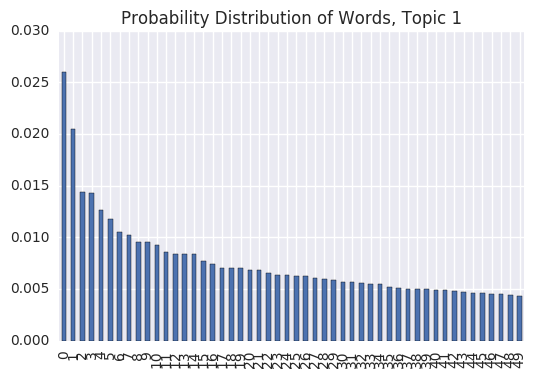

In [37]:
#the topics more distinct by changing the α and η  parameters of the model
# α controls the sparsity of document-topic loadings
# η  controls the sparsity of topic-word loadings.
topic1_df = pandas.DataFrame(NYTlda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

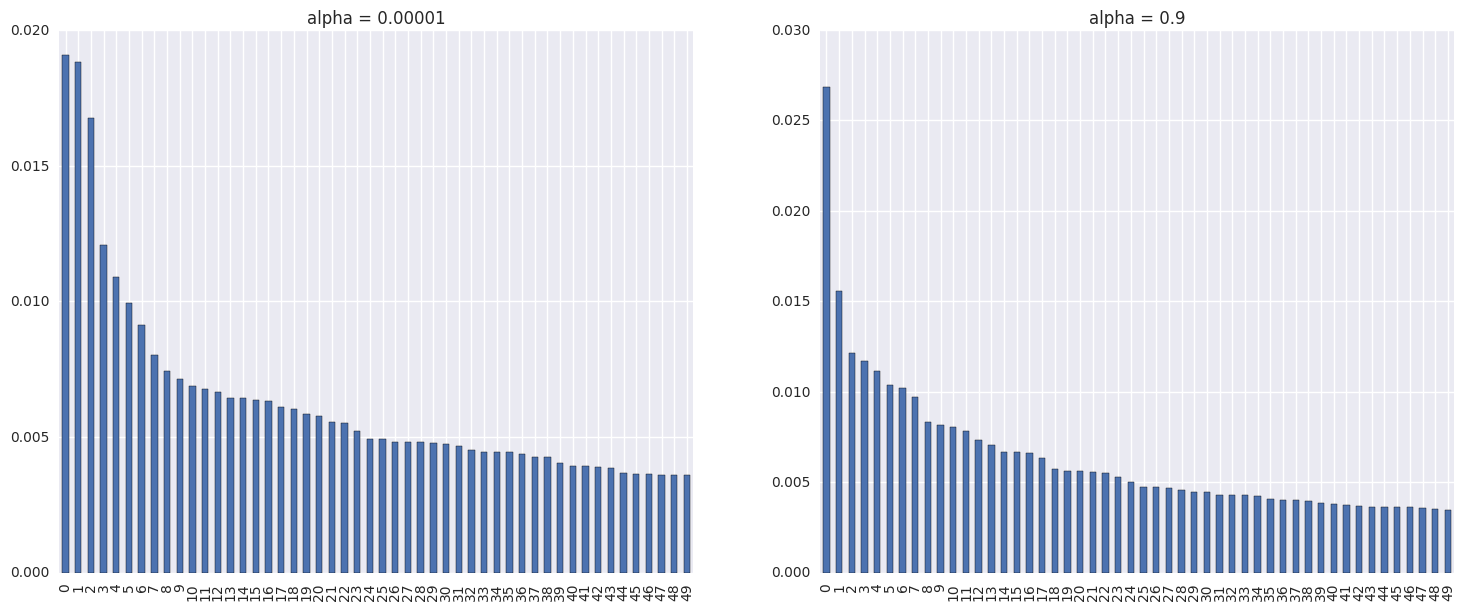

In [38]:
NYTlda1 = gensim.models.ldamodel.LdaModel(corpus=NYTmm, id2word=dictionary, num_topics=4, alpha = 0.00001)
NYTlda2 = gensim.models.ldamodel.LdaModel(corpus=NYTmm, id2word=dictionary, num_topics=4, alpha = 0.9)

topic11_df = pandas.DataFrame(NYTlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(NYTlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = 'alpha = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = 'alpha = 0.9')
plt.show()

In [71]:
# topic modeling and induction, with 6 topics.
NYTlda6 = gensim.models.ldamodel.LdaModel(corpus=NYTmm, id2word=dictionary, num_topics=6, alpha='auto', eta='auto')

#inspect the degree to which distinct texts load on different topics; one of the texts from the training set
NYT1Bow6 = dictionary.doc2bow(tokens['reduced_tokens'][0])
NYT1lda6 = NYTlda6[NYT1Bow6]
# print("The topics of the text: {}".format(tokens['title'][0]))
# print("are: {}".format(NYT1lda12))

In [72]:
# make each topic its own column:
ldaDF6= pandas.DataFrame({
        'title' : tokens['title'],
        'topics' : [NYTlda6[dictionary.doc2bow(l)] for l in tokens['reduced_tokens']]
    })

#Dict to temporally hold the probabilities
topicsProbDict6= {i : [0] * len(ldaDF6) for i in range(NYTlda6.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF6['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict6[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(NYTlda6.num_topics):
    ldaDF6['topic_{}'.format(topicNum)] = topicsProbDict6[topicNum]
    
# subset the data:
ldaDFV6 = ldaDF6[:10][['topic_%d' %x for x in range(6)]]
ldaDFVisN6 = ldaDF6[:10][['title']]
ldaDFVis6 = ldaDFV6.as_matrix(columns=None)
ldaDFVisNames6 = ldaDFVisN6.as_matrix(columns=None)
# ldaDFV20

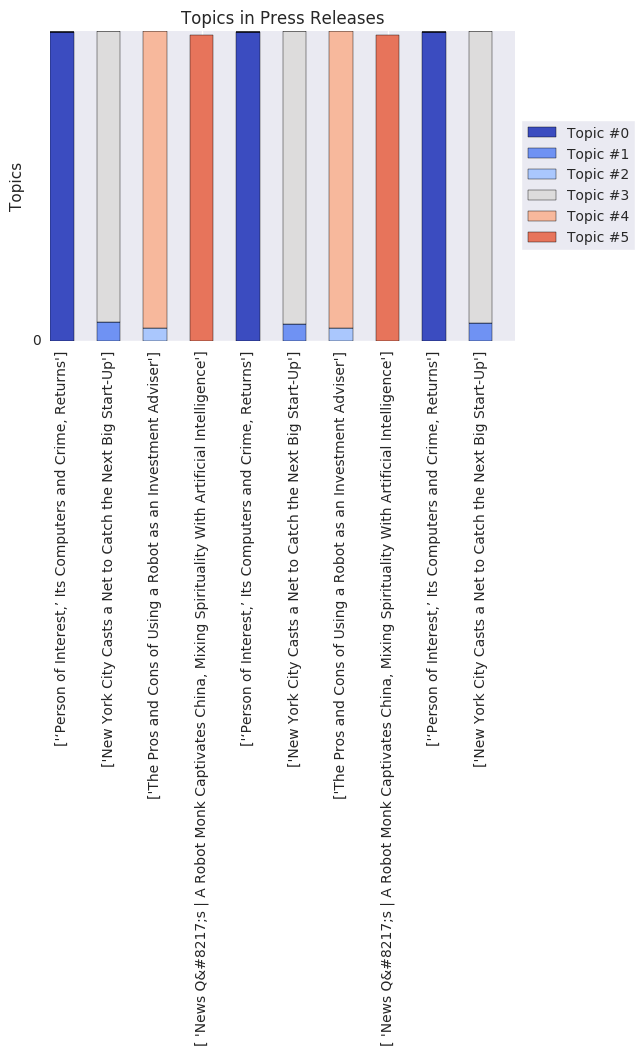

In [73]:
#visualize as a stacked bar chart:

N = 10
ind = np.arange(N)
K = NYTlda6.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis6[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis6[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis6[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames6, rotation='vertical')
plt.yticks(np.arange(0, 1, 10))

topic_labels6 = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels6, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

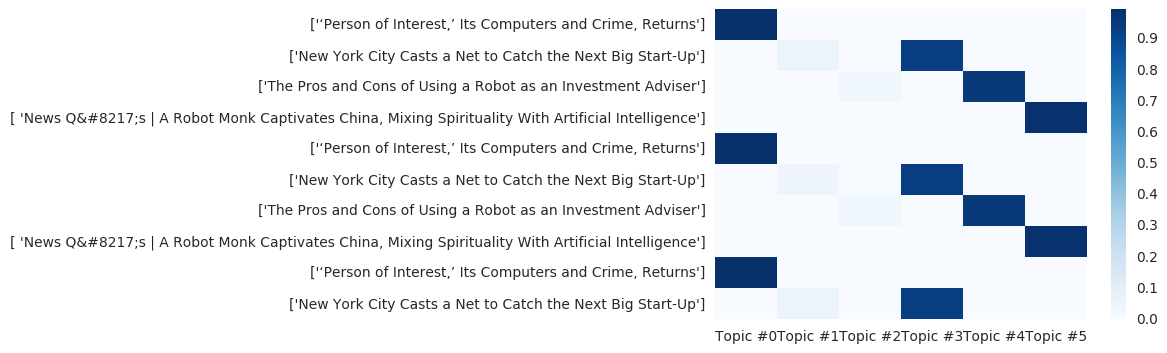

In [74]:
# visualize as a heat map:
plt.pcolor(ldaDFVis6, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis6.shape[0])+0.5, ldaDFVisNames6);
plt.xticks(np.arange(ldaDFVis6.shape[1])+0.5, topic_labels6);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
# plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
# plt.tight_layout()  # fixes margins
plt.show()

In [75]:
#look at the top words from each topic
NYTlda6.show_topic(1)

# make a dataFrame:
topicsDict6 = {}
for topicNum in range(NYTlda6.num_topics):
    topicWords6 = [w for w, p in NYTlda6.show_topic(topicNum)]
    topicsDict6['Topic_{}'.format(topicNum)] = topicWords6

wordRanksDF6 = pandas.DataFrame(topicsDict6)
wordRanksDF6

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5
0,season,york,york,york,invest,robot
1,make,said,invest,said,said,whi
2,program,tech,said,billion,york,question
3,think,billion,servic,tech,investor,york
4,york,ventur,provid,compani,servic,think
5,finch,compani,investor,year,firm,said
6,episod,servic,advis,invest,advis,read
7,tech,valley,tech,ventur,tech,monk
8,stori,firm,fiduciari,firm,provid,text
9,said,invest,firm,servic,billion,invest


# MEMO
For this homework, I have collected a set of New York Times articles using their API. I searched for articles with a search term "artificial intelligence". I omitted the API key in this notebook for the private use. For reproducibility of the result, I have saved my search result using pickle. Interestingly, the search result gives me a set of ariticles with a clear pattern, i.e. articles that belong to four sections: Art, Business day, Education, and Technology.

I tried the K-means clustering with `K == 4` in order to see how well the cluter will do in identifying sections. In other words, I sought to find whether articles in the same section are more similar to each other than to articles from other sections. The two colored scatter plots show that it may not be the case. Also, when I conducted the silhouette analysis to find the ideal number of clusters, `K`, the result suggested that when `2 <= K <= 6`, more clusters simply leads to a better result. In case of the hierarchical clustering, it was difficult for me to compare the result with the original sections, since it was difficult to identify what leads to each branching. In contrast, the topic modeling algorithm with four topics successfully (almost perfectly) matched each topic with the original sections. When I tried with six topics to make a quick comparison, the result again showed that there is a clear pattern of four groups that match the original sections.